# Neural Networks 神经网络
在这个练习中，你将实现反向传播算法来学习神经网络的参数。依旧是上次预测手写数数字的例子。

## Visualizing the data 可视化数据
这部分我们随机选取100个样本并可视化。训练集共有5000个训练样本，每个样本是20*20像素的数字的灰度图像。每个像素代表一个浮点数，表示该位置的灰度强度。20×20的像素网格被展开成一个400维的向量。在我们的数据矩阵X中，每一个样本都变成了一行，这给了我们一个5000×400矩阵X，每一行都是一个手写数字图像的训练样本。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as opt
from sklearn.metrics import classification_report  # 这个包是评价报告

In [2]:
def load_mat(path):
    '''读取数据'''
    data = loadmat('ex4data1.mat')  # return a dict
    X = data['X']
    y = data['y'].flatten()
    
    return X, y  

In [3]:
def plot_100_images(X):
    """随机画100个数字"""
    index = np.random.choice(range(5000), 100)
    images = X[index]
    fig, ax_array = plt.subplots(10, 10, sharey=True, sharex=True, figsize=(8, 8))
    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(images[r*10 + c].reshape(20,20), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

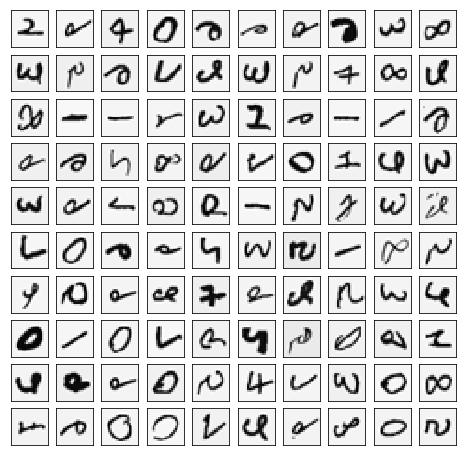

In [4]:
X,y = load_mat('ex4data1.mat')
plot_100_images(X)

## Model representation 模型表示
我们的网络有三层，输入层，隐藏层，输出层。我们的输入是数字图像的像素值，因为每个数字的图像大小为20*20，所以我们输入层有400个单元（这里不包括总是输出要加一个偏置单元）。

### load train data set 读取数据
首先我们要将标签值（1，2，3，4，…，10）转化成非线性相关的向量，向量对应位置（y[i-1]）上的值等于1，例如y[0]=6转化为y[0]=[0,0,0,0,0,1,0,0,0,0]。

In [5]:
from sklearn.preprocessing import OneHotEncoder
def expand_y(y):
    result = []
    # 把y中每个类别转化为一个向量，对应的lable值在向量对应位置上置为1
    for i in y:
        y_array = np.zeros(10)
        y_array[i-1] = 1
        result.append(y_array)
    '''
    # 或者用sklearn中OneHotEncoder函数
    encoder =  OneHotEncoder(sparse=False)  # return a array instead of matrix
    y_onehot = encoder.fit_transform(y.reshape(-1,1))
    return y_onehot
    ''' 
    return np.array(result)

获取训练数据集，以及对训练集做相应的处理，得到我们的input X，lables y。

In [6]:
raw_X,raw_y=load_mat('ex4data1.mat')
X=np.insert(raw_X,0,1,axis=1)
y=expand_y(raw_y)
y.shape

(5000, 10)

###  load weight 读取权重
这里我们提供了已经训练好的参数θ1，θ2，存储在ex4weight.mat文件中。这些参数的维度由神经网络的大小决定，第二层有25个单元，输出层有10个单元(对应10个数字类)。

In [7]:
def load_weight(path):
    data=loadmat(path)
    return data['Theta1'],data['Theta2']

In [8]:
t1, t2 = load_weight('ex4weights.mat')
t1.shape, t2.shape

((25, 401), (10, 26))

### 展开参数
当我们使用高级优化方法来优化神经网络时，我们需要将多个参数矩阵展开，才能传入优化函数，然后再恢复形状。

In [9]:
def serialize(a, b):
    '''展开参数'''
    return np.r_[a.flatten(),b.flatten()]

In [10]:
theta = serialize(t1, t2)  # 扁平化参数，25*401+10*26=10285
theta.shape

(10285,)

In [11]:
def deserialize(seq):
    '''提取参数'''
    return seq[:25*401].reshape(25, 401), seq[25*401:].reshape(10, 26)

## Feedforward and cost function 前馈和代价函数

### Feedforward
确保每层的单元数，注意输出时加一个偏置单元，s(1)=400+1，s(2)=25+1，s(3)=10。

In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [13]:
def feed_forward(theta, X):
    '''得到每层的输入和输出'''
    t1, t2 = deserialize(theta)
    # 前面已经插入过偏置单元，这里就不用插入了
    a1 = X
    z2 = a1.dot(t1.T)
    a2 = np.insert(sigmoid(z2), 0, 1, axis=1)
    z3 = a2.dot(t2.T)
    a3 = sigmoid(z3)
    
    return a1, z2, a2, z3, a3 

In [14]:
a1, z2, a2, z3, h = feed_forward(theta, X)

### Cost function
输出层输出的是对样本的预测，包含5000个数据，每个数据对应了一个包含10个元素的向量，代表了结果有10类。在公式中，每个元素与log项对应相乘。

最后我们使用提供训练好的参数θ，算出的cost应该为0.287629

In [15]:
def cost(theta,X,y):
    a1, z2, a2, z3, h = feed_forward(theta, X)
    J=0
    for i in range(y.shape[0]):
        first=-y[i].dot(np.log(h[i].T))
        second=-(1-y[i]).dot(np.log((1-h[i]).T))
        J=J+first+second
    J=J/y.shape[0]
    return J
    '''
    # or just use verctorization
    J = - y * np.log(h) - (1 - y) * np.log(1 - h)
    return J.sum() / len(X)
    '''

In [16]:
cost(theta, X, y)

0.2876291651613186

## Regularized cost function 正则化代价函数
注意不要将每层的偏置项正则化。

最后You should see that the cost is about 0.383770

In [17]:
def regularized_cost(theta, X, y, l=1):
    '''正则化时忽略每层的偏置项，也就是参数矩阵的第一列'''
    t1, t2 = deserialize(theta)
    reg = np.sum(t1[:,1:] ** 2) + np.sum(t2[:,1:] ** 2)  # or use np.power(a, 2)
    return l / (2 * len(y)) * reg + cost(theta, X, y)

In [18]:
regularized_cost(theta, X, y, 1)  # 0.38376985909092354

0.3837698590909233

# Backpropagation 反向传播

## Sigmoid gradient S函数导数

In [19]:
def sigmoidGradient(z):
    return sigmoid(z) * ((1 - sigmoid(z)))

## Random initialization 随机初始化
当我们训练神经网络时，随机初始化参数是很重要的，可以打破数据的对称性。一个有效的策略是在均匀分布(−e，e)中随机选择值，我们可以选择 e = 0.12 这个范围的值来确保参数足够小，使得训练更有效率

In [20]:
def randInitializeWeights(size):
    '''从服从的均匀分布的范围中随机返回size大小的值'''
    return np.random.uniform(-0.12, 0.12, size)

## Backpropagation 反向传播
目标：获取整个网络代价函数的梯度。以便在优化算法中求解。

这里面一定要理解正向传播和反向传播的过程，才能弄清楚各种参数在网络中的维度，切记。比如手写出每次传播的式子。

In [21]:
def gradient(theta, X, y):
    '''
    unregularized gradient, notice no d1 since the input layer has no error 
    return 所有参数theta的梯度，故梯度D(i)和参数theta(i)同shape，重要。
    '''
    t1, t2 = deserialize(theta)
    a1, z2, a2, z3, h = feed_forward(theta, X)
    d3 = h - y  # (5000, 10)
    d2 = d3 .dot(t2[:, 1:]) * sigmoidGradient(z2)  # (5000, 25)
    D2 = d3.T.dot(a2)  # (10, 26)
    D1 = d2.T.dot(a1)  # (25, 401)
    D = (1 / len(y)) * serialize(D1, D2)  # (10285,)

    return D

## Regularized Neural Networks 正则化神经网络
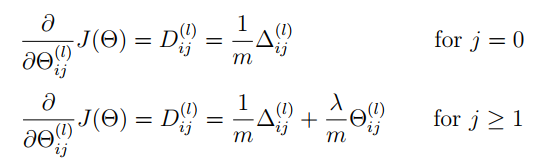

In [22]:
def regularized_gradient(theta, X, y, l=1):
    """不惩罚偏置单元的参数"""
    a1, z2, a2, z3, h = feed_forward(theta, X)
    D1, D2 = deserialize(gradient(theta, X, y))
    t1[:,0] = 0
    t2[:,0] = 0
    reg_D1 = D1 + (l / len(y)) * t1
    reg_D2 = D2 + (l / len(y)) * t2
    
    return serialize(reg_D1, reg_D2)

## Gradient checking 梯度检测
在你的神经网络,你是最小化代价函数J(Θ)。执行梯度检查你的参数,你可以想象展开参数Θ(1)Θ(2)成一个长向量θ。通过这样做,你能使用以下梯度检查过程。
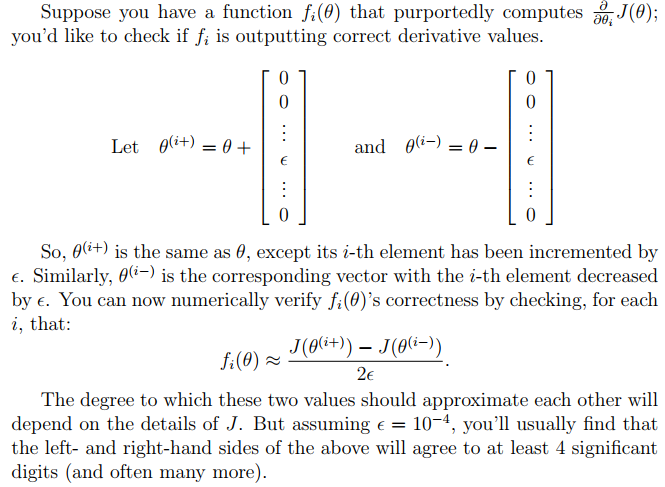

In [23]:
def checkNNGradients(theta, X, y, epsilon):
    def computeNumericalGradient(plus, minus):
        """
        对每个参数theta_i计算数值梯度，即理论梯度。
        """
        return (regularized_cost(plus, X, y) - regularized_cost(minus, X, y)) / (epsilon * 2)

    NumericalGradient = []
    for i in range(len(theta)):
        plus = theta.copy()  # deep copy otherwise you will change the raw theta
        minus = theta.copy()
        plus[i] = plus[i] + epsilon
        minus[i] = minus[i] - epsilon
        grad_i = computeNumericalGradient(plus, minus)
        NumericalGradient.append(grad_i)

    NumericalGradient = np.array(NumericalGradient)
    AnalyticGradient = regularized_gradient(theta, X, y)
    diff = np.linalg.norm(NumericalGradient - AnalyticGradient) \
        /np.linalg.norm(NumericalGradient + AnalyticGradient)

    print('If your backpropagation implementation is correct,\nthe relative difference will be smaller than 10e-9 (assume epsilon=0.0001).\nRelative Difference: {}\n'.format(diff))

In [24]:
checkNNGradients(theta, X, y, epsilon= 0.0001)#这个运行很慢，谨慎运行

If your backpropagation implementation is correct,
the relative difference will be smaller than 10e-9 (assume epsilon=0.0001).
Relative Difference: 1.4784042943911656e-08



## Learning parameters using fmincg 优化参数

In [25]:
def nn_training(X, y):
    init_theta = randInitializeWeights(10285)  # 25*401 + 10*26

    res = opt.minimize(fun=regularized_cost,
                       x0=init_theta,
                       args=(X, y, 1),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'maxiter': 400})
    return res

In [26]:
res = nn_training(X, y)#慢
res
'''
     fun: 0.5156784004838036
     jac: array([-2.51032294e-04, -2.11248326e-12,  4.38829369e-13, ...,
        9.88299811e-05, -2.59923586e-03, -8.52351187e-04])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 271
     nit: 17
  status: 1
 success: True
       x: array([ 0.58440213, -0.02013683,  0.1118854 , ..., -2.8959637 ,
        1.85893941, -2.78756836])
'''

<ipython-input-15-b7869be9a421>:6: RuntimeWarning: divide by zero encountered in log
  second=-(1-y[i]).dot(np.log((1-h[i]).T))


"\n     fun: 0.5156784004838036\n     jac: array([-2.51032294e-04, -2.11248326e-12,  4.38829369e-13, ...,\n        9.88299811e-05, -2.59923586e-03, -8.52351187e-04])\n message: 'Converged (|f_n-f_(n-1)| ~= 0)'\n    nfev: 271\n     nit: 17\n  status: 1\n success: True\n       x: array([ 0.58440213, -0.02013683,  0.1118854 , ..., -2.8959637 ,\n        1.85893941, -2.78756836])\n"

In [27]:
def accuracy(theta, X, y):
    _, _, _, _, h = feed_forward(res.x, X)
    y_pred = np.argmax(h, axis=1) + 1
    print(classification_report(y, y_pred))

In [28]:
accuracy(res.x, X, raw_y)
'''
             precision    recall  f1-score   support

          1       0.97      0.99      0.98       500
          2       0.98      0.97      0.98       500
          3       0.98      0.95      0.96       500
          4       0.98      0.97      0.97       500
          5       0.97      0.98      0.97       500
          6       0.99      0.98      0.98       500
          7       0.99      0.97      0.98       500
          8       0.96      0.98      0.97       500
          9       0.97      0.98      0.97       500
         10       0.99      0.99      0.99       500

avg / total       0.98      0.98      0.98      5000
'''

              precision    recall  f1-score   support

           1       0.98      0.99      0.98       500
           2       0.98      0.98      0.98       500
           3       0.99      0.96      0.97       500
           4       0.98      0.98      0.98       500
           5       0.98      0.98      0.98       500
           6       0.98      0.98      0.98       500
           7       0.97      0.97      0.97       500
           8       0.98      0.99      0.99       500
           9       0.97      0.97      0.97       500
          10       0.99      0.99      0.99       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



'\n             precision    recall  f1-score   support\n\n          1       0.97      0.99      0.98       500\n          2       0.98      0.97      0.98       500\n          3       0.98      0.95      0.96       500\n          4       0.98      0.97      0.97       500\n          5       0.97      0.98      0.97       500\n          6       0.99      0.98      0.98       500\n          7       0.99      0.97      0.98       500\n          8       0.96      0.98      0.97       500\n          9       0.97      0.98      0.97       500\n         10       0.99      0.99      0.99       500\n\navg / total       0.98      0.98      0.98      5000\n'

# Visualizing the hidden layer 可视化隐藏层
理解神经网络是如何学习的一个很好的办法是，可视化隐藏层单元所捕获的内容。通俗的说，给定一个的隐藏层单元，可视化它所计算的内容的方法是找到一个输入x，x可以激活这个单元（也就是说有一个激活值a接近与1）。对于我们所训练的网络，注意到θ1中每一行都是一个401维的向量，代表每个隐藏层单元的参数。如果我们忽略偏置项，我们就能得到400维的向量，这个向量代表每个样本输入到每个隐层单元的像素的权重。因此可视化的一个方法是，reshape这个400维的向量为（20，20）的图像然后输出。

注：
It turns out that this is equivalent to finding the input that gives the highest activation for the hidden unit, given a norm constraint on the input.

这相当于找到了一个输入，给了隐层单元最高的激活值，给定了一个输入的标准限制。

In [29]:
def plot_hidden(theta):
    t1, _ = deserialize(theta)
    t1 = t1[:, 1:]
    fig,ax_array = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(6,6))
    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(t1[r * 5 + c].reshape(20, 20), cmap='gray_r')
            plt.xticks([])
            plt.yticks([])
    plt.show()

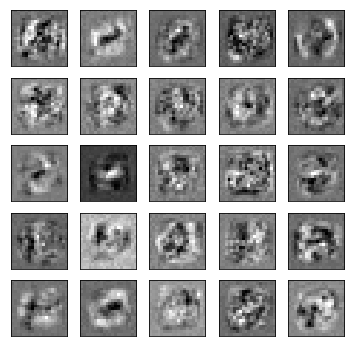

In [30]:
plot_hidden(res.x)
# 在我们经过训练的网络中，你应该发现隐藏的单元大致对应于在输入中寻找笔画和其他模式的检测器。